# Sheet 3

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import torch

## 2 Projection Trick

In [9]:
# # Generate data
# xy = np.random.uniform(-1, 1, size=(500, 2))
# r = np.median(np.linalg.norm(xy, axis=-1))
# labels = (np.linalg.norm(xy, axis=-1) < r).astype(np.int32)

# np.save('data/data2d.npy', xy)
# np.save('data/labels.npy', labels)

(array([0, 1], dtype=int32), array([250, 250]))


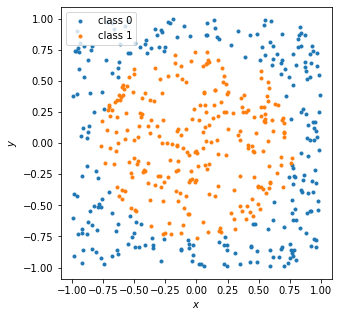

In [10]:
# Load the data
xy = np.load('data03/data2d.npy')
labels = np.load('data03/labels.npy')

# TODO: plot the data
print(np.unique(labels, return_counts=True))
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(*xy[labels==0].T, marker='.', label='class 0')
ax.scatter(*xy[labels==1].T, marker='.', label='class 1')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend()
ax.set_aspect('equal')

Accuracy: 55.80%


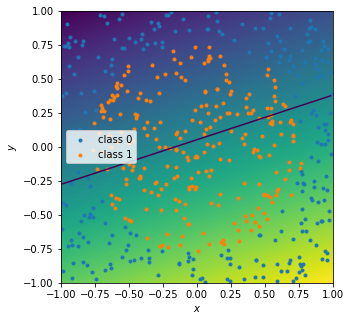

In [11]:
from sklearn.linear_model import LogisticRegression
# TODO: fit logistic regression
regressor = LogisticRegression()
regressor.fit(xy, labels)

grid = np.stack(np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)), axis=-1)

# TODO: compute the accuracy
pred_labels = regressor.predict(xy)
print(f'Accuracy: {(pred_labels==labels).mean():.2%}')

# TODO: visualize decision boundary
pred = regressor.decision_function(grid.reshape(-1,2)).reshape(grid.shape[:-1]).T
fig, ax = plt.subplots(figsize=(5, 5))

plt.imshow(pred, origin='lower', extent=(-1, 1, -1, 1))
plt.contour(pred, levels=[0], origin='lower', extent=(-1, 1, -1, 1))
ax.scatter(*xy[labels==0].T, marker='.', label='class 0')
ax.scatter(*xy[labels==1].T, marker='.', label='class 1')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend()
ax.set_aspect('equal')

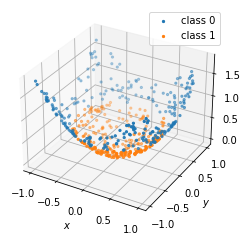

In [12]:
# TODO: Come up with a nonlinear tranformation for the third feature. Compute it and concatenate to the data.

xyz = np.concatenate([xy, xy[:, :1]**2 + xy[:, 1:]**2], axis=-1)

# TODO: Show the enhanced data, e.g. with a 3D scatter plot 
#       (https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

ax.scatter(*xyz[labels==0].T, marker='.', label='class 0')
ax.scatter(*xyz[labels==1].T, marker='.', label='class 1')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.legend()
plt.show()

In [13]:
# TODO: again, fit and evaluate logistic regression
regressor = LogisticRegression()
regressor.fit(xyz, labels)

regressor
grid = np.stack(np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)), axis=-1)

pred = regressor.predict(xyz)

print(f'Accuracy: {(pred==labels).mean():.2%}')

Accuracy: 99.00%


### The below was not neccesary for the task, just a computational way to solve the last part
Train an MLP to solve the task and visualize the neurons

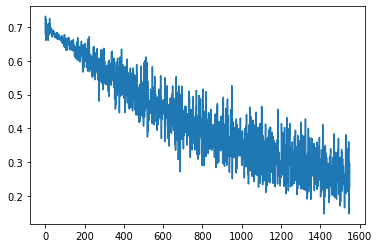

0.962

In [14]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, Adam

class Net(torch.nn.Module):
    def __init__(self, n_hidden_features=20):
        super().__init__()
        self.linear1 = nn.Linear(2, n_hidden_features)
        self.linear2 = nn.Linear(n_hidden_features, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = nn.functional.relu(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        return x
    
    
model = Net(32)
criterion = torch.nn.BCELoss()

dset = TensorDataset(torch.from_numpy(xy).float(), 
                     torch.from_numpy(labels[:, None]).float())
loader = DataLoader(dset, batch_size=16, shuffle=True, drop_last=True)
optimizer = Adam(model.parameters(), lr=1e-3)
# optimizer = SGD(model.parameters(), lr=0.1)

def get_acc():
    acc = []
    for x, y in dset:
        optimizer.zero_grad()
        y_pred = model(x)
        acc.extend(((y_pred > 0.5) == y).detach().numpy())
    return np.array(acc).mean()

losses = []
for epoch in range(50):
    for x, y in loader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
plt.plot(losses)
plt.show()
get_acc()

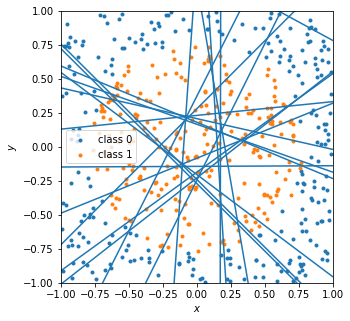

In [15]:
def visualize_linear(bound=1):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(*xy[labels==0].T, marker='.', label='class 0')
    ax.scatter(*xy[labels==1].T, marker='.', label='class 1')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.legend()
    ax.set_aspect('equal')

    # visualize the neurons
    for i, (b, w) in enumerate(zip(model.linear1.bias.detach().numpy(), model.linear1.weight.detach().numpy())):
        ax.axline((0, -b/w[1]), (-b/w[0], 0))

    plt.xlim(-bound, bound)
    plt.ylim(-bound, bound)
    plt.show()
    
visualize_linear()

Construct weights that work by hand

0.7794307887657059


<ipython-input-15-cbcc74b20703>:12: RuntimeWarning: divide by zero encountered in float_scalars
  ax.axline((0, -b/w[1]), (-b/w[0], 0))


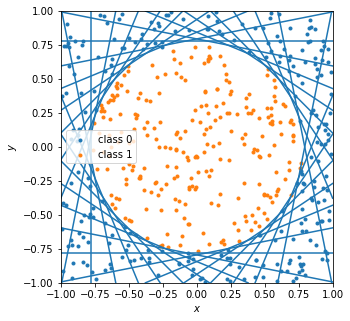

0.996

In [16]:
# initialize model by hand
n = len(model.linear1.weight)
r = np.max(np.linalg.norm(xy[labels==1], axis=-1))# / np.sqrt(2))
print(r)
steepness = 1000

model.linear1.weight.data = torch.stack([torch.FloatTensor([np.cos(2*np.pi/n * i), np.sin(2*np.pi/n * i)]) for i in range(n)])

model.linear1.bias.data[:] = -r

model.linear2.bias.data[:] = 1
model.linear2.weight.data[:] = -steepness

visualize_linear()
get_acc()

## 3) Linear regions of MLPs

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# define NN architecture.
class shallowMLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(2, 20)
        self.linear2 = nn.Linear(20, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # TODO: pass the input x through the layers and return the output
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [ ]:
class Abs(nn.Module):
    """Absolute value activation function. You can experiment with this instead of ReLU."""
    def forward(self, x):
        return x.abs()

def visualize_model(model, res=500, bound=5):
    # TODO: implement a function that takes the model (the MLP), and builds a 
    #       grid of points in [-bound, bound] x [-bound, bound], passes them 
    #       through the model and returns the result in the shape of an image
    
    with torch.no_grad():
        x = torch.linspace(-bound, bound, res)
        y = torch.linspace(-bound, bound, res)
        xy = torch.stack(torch.meshgrid(x, y, indexing='ij'), axis=-1)
        xy = xy.reshape(-1, 2)
        out = model(xy).reshape(res, res)
    return out

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_features, activation=nn.ReLU, softmax=False):
        super().__init__()
        
        layers = []
        n_layers = len(n_features)
        for i, (f_in, f_out) in enumerate(zip(n_features[:-1], n_features[1:])):
            lin = nn.Linear(f_in, f_out)
            layers.append(lin)
            if i != n_layers-2:
                layers.append(activation())
        
        # optionally, add a softmax
        if softmax:
            layers.append(nn.Softmax())
        self.softmax = softmax
        
        self.layers = nn.ModuleList(layers)
        
        
    def forward(self, x):
        # TODO: pass the input x through the layers and return the output
        for layer in self.layers:
            x = layer(x)
            
        if self.softmax:
            x = self.softmax(x, dim=-1)
            
        return x 

--------------------------------------------------------------------------------
Run 0
# parameters = 81
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)


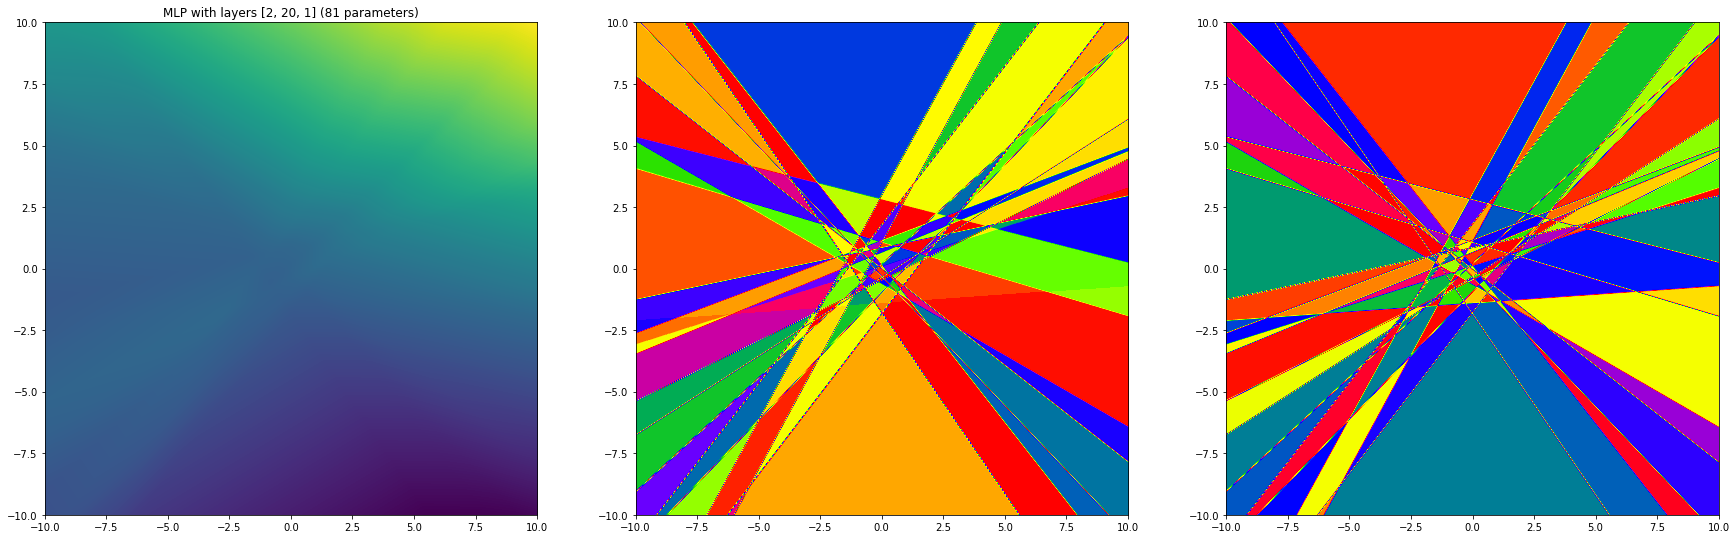

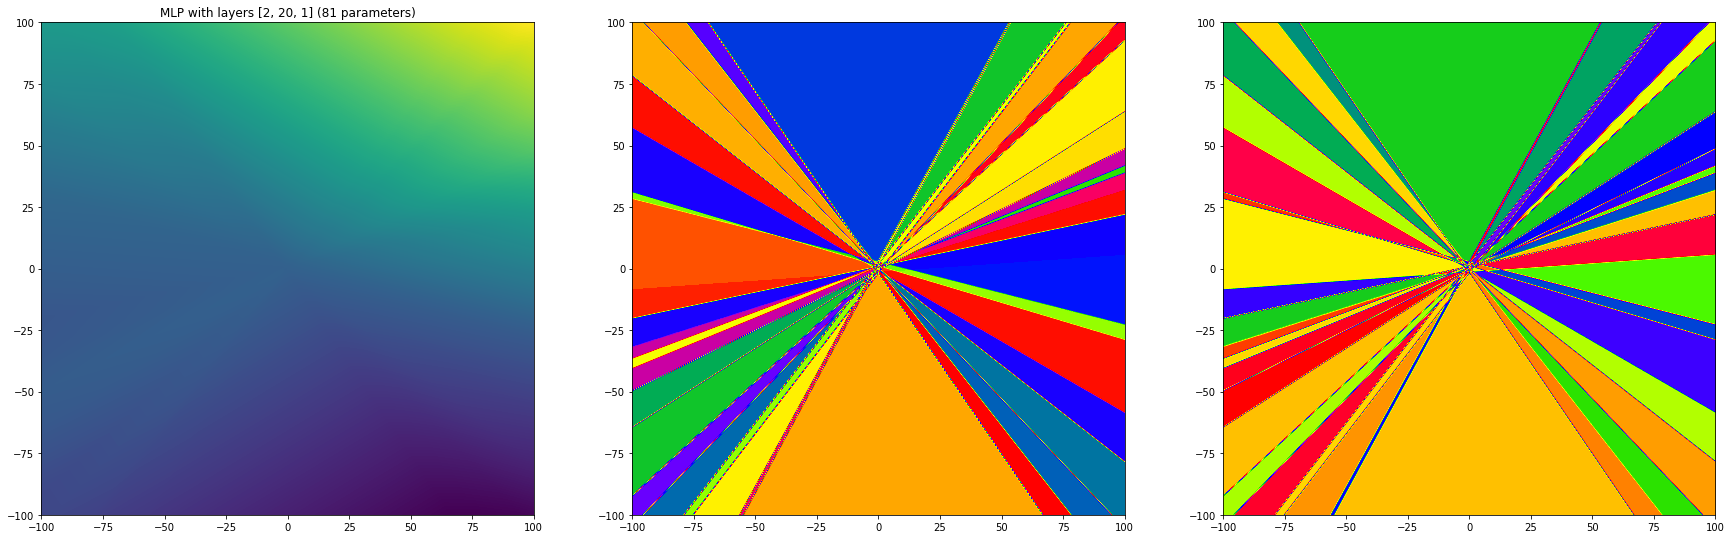

# parameters = 111
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=5, bias=True)
    (7): ReLU()
    (8): Linear(in_features=5, out_features=1, bias=True)
  )
)


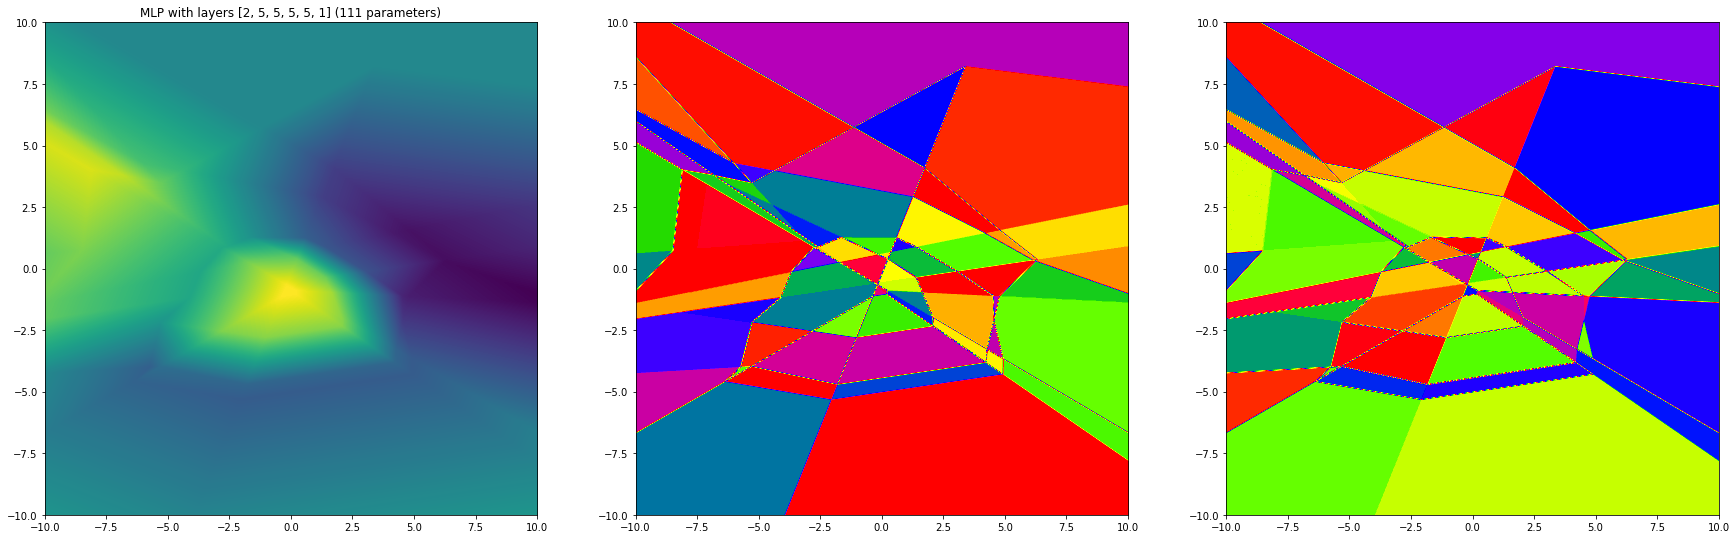

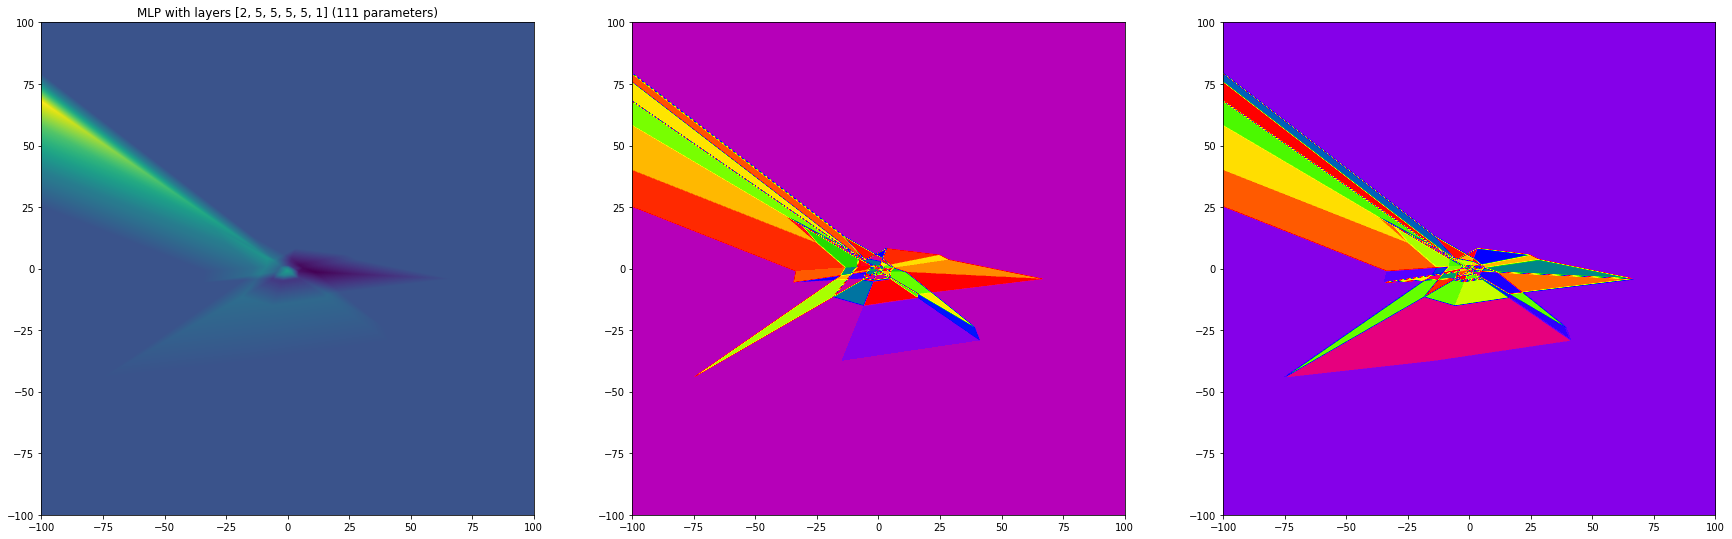

# parameters = 81
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)


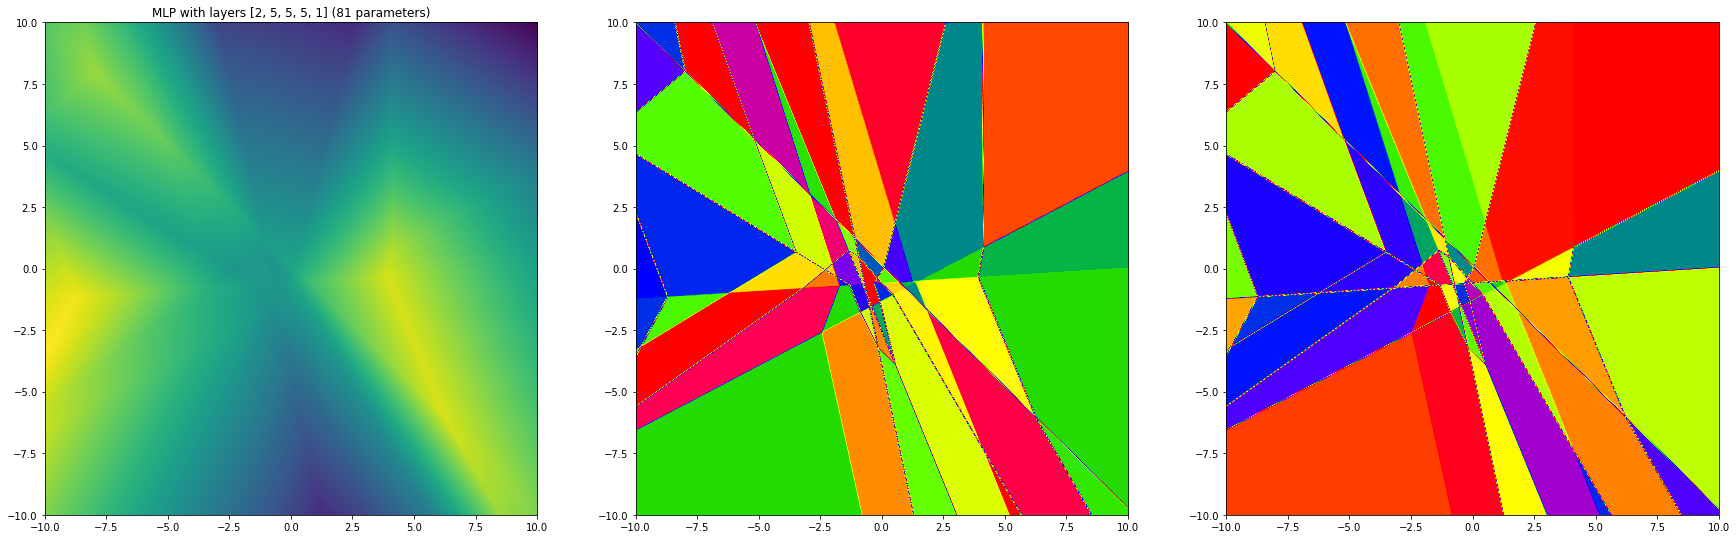

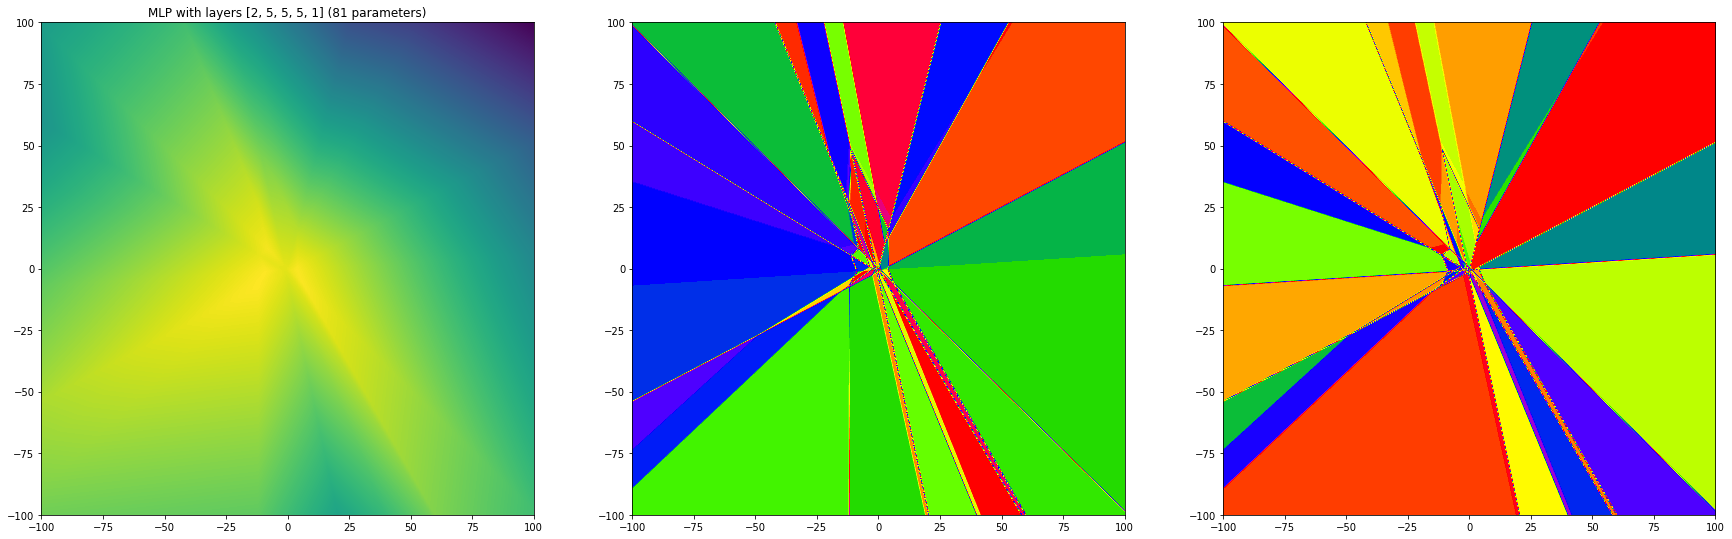

In [24]:
# TODO: instantiate the model and make the visualizations as requested in the task

feature_configs = [
    [2, 20, 1],
    [2, 5, 5, 5, 5, 1],
    [2, 5, 5, 5, 1],
]

figsize=(10, 10)
for i in range(1):
    print('-'*80)
    print(f'Run {i}')
    for features in feature_configs:
        model = MLP(features, activation=nn.ReLU)
        # model = MLP(features, activation=Abs)
        print(f"# parameters = {count_parameters(model)}")
        print(model)
        for bound in (10,100):
            out = visualize_model(model, res=2000, bound=bound)
            fig, axs = plt.subplots(1, 3, figsize=(30, 10))
            axs[0].set_title(f'MLP with layers {features} ({count_parameters(model)} parameters)')
            extent = (-bound, bound, -bound, bound)
            axs[0].imshow(out.T, extent=extent, origin='lower')
            
            grad = np.gradient(out, 2)
            img = axs[1].imshow(grad[0].T / (2*bound/2000), extent=extent, origin='lower', cmap='prism')
            img = axs[2].imshow(grad[1].T / (2*bound/2000), extent=extent, origin='lower', cmap='prism')
            
            plt.show()